## Analysis with 2-by-2 model Hamiltonian
Based on Benjamin J. Carlson *et al.*, *J. Phys. Chem. Lett.* **12**, 1202-1206 (2021)


In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import optimize

sys.path.append('../../Python_libs')
import stabtools as st

#matplotlib.use('Qt5Agg')
%matplotlib inline

***
# Read-in stabilization data

In [2]:
Angs2Bohr=1.8897259886
au2eV=27.211386027
au2cm=219474.63068
#
#  files in the current directory do not need the path name
#
df=pd.read_csv("DVR_stab_plot.csv")
#df=pd.read_csv("GTO_TZ_stab_plot.csv")
df.head()

,L,z,E1,E2,E3,E4,E5,E6
0,1.423025,0.493827,-7.170508,0.159275,0.523245,1.098066,1.858843,2.728974
1,1.399532,0.510545,-7.170508,0.165750,0.545553,1.144416,1.933952,2.814184
2,1.377166,0.527263,-7.170508,0.172307,0.568155,1.191240,2.009268,2.890628
3,1.355838,0.543981,-7.170508,0.178946,0.591050,1.238525,2.084680,2.956664
4,1.335472,0.560700,-7.170508,0.185668,0.614238,1.286256,2.160057,3.011986


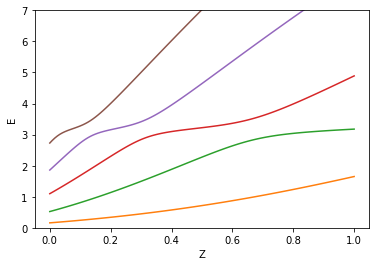

In [3]:
z_col=df.columns[1]
all_zs=df[z_col].values
zmin, zmax = all_zs[0], all_zs[-1]
if zmax < zmin:
    zmin, zmax = zmax, zmin
all_zs=(all_zs-zmin)/(zmax-zmin)

E_labels=df.columns[2:]
plt.cla()
plt.xlabel('Z')
plt.ylabel('E')
for E in E_labels:
    plt.plot(all_zs, df[E].values, '-')
plt.ylim(0,7)
plt.show()

Set the following parameters after inspecting the stabilization plot:
* lroot: the lower root; the 2nd root is lroot+1
* curvature_cutoff: the crossing is defined by the minimum and maximum curvature positions; the  selection range is determined by the drop off of the abs(curvature) 

Center of the crossing at z=0.30833333
N = 15 points on each curve


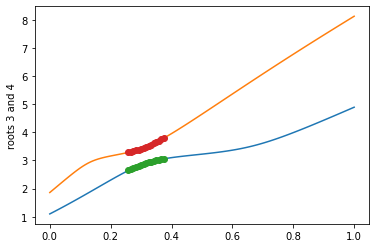

In [4]:
lroot = 3
curvature_cutoff=0.5

E_lw=df[E_labels[lroot]].values
E_up=df[E_labels[lroot+1]].values
success, cross_center, zs, E1s, E2s = st.crossing(all_zs, E_lw, E_up, curvature_cutoff)

if success:
    print(f'Center of the crossing at z={cross_center:.8f}')
    npts = len(zs)
    print(f'N = {npts} points on each curve')
    plt.cla()
    plt.plot(all_zs, E_lw, all_zs, E_up)
    plt.plot(zs, E1s, 'o', zs, E2s, 'o')
    plt.ylabel('roots '+str(lroot)+' and '+str(lroot+1))
    plt.show()
else:
    print('No crossing found.')
    zcs = (all_zs[zs[0]], all_zs[zs[1]])
    print('min/max curvature at z=%f and z=%f' % zcs)
    plt.cla()
    plt.plot(all_zs, E1s, all_zs, E2s)
    plt.ylabel('curvature '+str(lroot)+' and '+str(lroot+1))
    plt.show()
    


Combining the upper and lower curve into one list for fitting.

In [5]:
Es = np.append(E1s, E2s)

***
## Defining Fit Function
$E_{\pm}=\frac{H_{11}+H_{22}}{2}\pm \frac{1}{2}\sqrt{(H_{11}-H_{22})^{2}+4H_{12}^{2}}$

where  
$H_{11}=a_{0}$  
$H_{22}=a_{0}+a_{1}(z-z_{1})$  
$H_{12}^{2}=A+B(z-z_{1})^{2}$   

With free parameters: $a_{0}$, $a_{1}$, $A$, $B$, $z_{1}$

In [6]:
def eqn_3(z, a0, a1, A, B, z1):
    '''Returns an (E-, E+) value for z'''
 
    H11 = a0
    H22 = a0 + a1*(z-z1)
    H122 = A + B*(z-z1)**2
    
    f1 = (H11+H22)*0.5
    f2 = 0.5*((H11-H22)**2+4*H122)**0.5
   
    return np.append(f1-f2, f1+f2) #returns (E-, E+) for a list of Zs

def eqn_3_lsq(params, xdata, ydata):
    '''Returns residuals for eqn_3'''
    a0, a1, A, B, z1 = params
    return eqn_3(xdata, a0, a1, A, B, z1)-ydata


Additionally, to fit using least squares directly, a function returning residuals is needed (eqn_3_lsq)

***
## Guessing start parameters


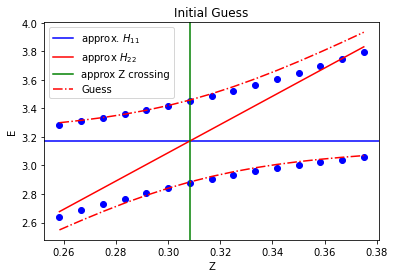

chi^2: 0.07661583
Guess parameters:
a0              a1              A              B              z1             
3.17151634      9.88997813      0.08219437     -1.00000000    0.30833333     


In [7]:
# Parameters to guess:a0, a1, A, B, z1

a0 = E2s[0]-(E2s[0]-E1s[-1])/2
a1=(E1s[0]-E2s[-1])/(zs[0]-zs[-1]) # slope of H22
A = (min(E2s-E1s)/2)**2 # approxiamte min distance between upper and lower squared
B = -1.0 # Guess arbitrary, negative number
z1 = cross_center
guess = [a0, a1, A, B, z1]

plt.cla()
plt.title('Initial Guess')
plt.xlabel('Z')
plt.ylabel('E')
plt.plot(zs, E1s, 'bo')  # plot original data
plt.plot(zs, E2s, 'bo')

plt.axhline(y=a0,color='b',label='approx. $H_{11}$')
plt.plot(zs,a0+a1*(zs-z1),'r-',label='approx $H_{22}$')
plt.axvline(x=z1,color='g', label='approx Z crossing')

Zplot=np.linspace(zs[0],zs[-1],npts) # create npts between min and max Z range from original data
Eplot = eqn_3(Zplot,a0, a1, A, B, z1)
plt.plot(Zplot, Eplot[:len(Eplot)//2],'r-.', label='Guess') # plot guess function with npts
plt.plot(Zplot, Eplot[len(Eplot)//2:],'r-.')

plt.legend()
plt.show()

# chi^2
Esfit = eqn_3(zs, a0, a1, A, B, z1)
chi2 = sum((Esfit-Es)**2)
print(f'chi^2: {chi2:.8f}')

print('Guess parameters:')
print ("{:<15} {:<15} {:<15}{:<15}{:<15}".format('a0','a1','A','B','z1'))
print ("{:<15.8f} {:<15.8f} {:<15.8f}{:<15.8f}{:<15.8f}".format(a0,a1,A,B,z1))

***
## Fitting Results and $\chi^{2}$

After fitting, the stationary point and resonance energy are extracted from:

$z^{*}=z_{1}-i\sqrt{\frac{a_{1}A}{|B|(A_{1}^{2}+4B)}}$

$E_{res}=a_{0}-2i\left[\left(\frac{\sqrt{A|B|}}{\sqrt{4B+a_{1}^{2}}}\right)\right]$

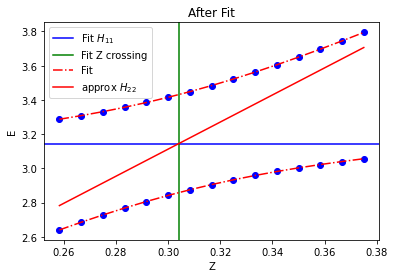

Optimized parameters:
a0              a1              A              B              z1             
3.14488392      7.91363172      0.08193481     -4.89077002    0.30408393     

Results:
Z* = 0.304084-0.055486
Eres = 3.144884 -0.192932
chi^2: 0.00000530


In [8]:
# fit then extract parameters
params = scipy.optimize.curve_fit(eqn_3, zs, Es, p0=guess)
a0, a1, A, B, z1 = params[0]

plt.cla()
plt.title('After Fit')
plt.xlabel('Z')
plt.ylabel('E')
plt.plot(zs, E1s, 'bo')  # plot original data
plt.plot(zs, E2s, 'bo')
plt.axhline(y=a0,color='b',label='Fit $H_{11}$')
plt.axvline(x=z1,color='g', label='Fit Z crossing')

Zplot=np.linspace(zs[0],zs[-1],npts) # create npts between min and max Z range from original data
Eplot = eqn_3(Zplot,a0, a1, A, B, z1)
plt.plot(Zplot, Eplot[:len(Eplot)//2],'r-.', label='Fit') # plot Fitted function with npts
plt.plot(Zplot, Eplot[len(Eplot)//2:],'r-.')
plt.plot(zs,a0+a1*(zs-z1),'r-',label='approx $H_{22}$')

plt.legend()
plt.show()


print('Optimized parameters:')
print ("{:<15} {:<15} {:<15}{:<15}{:<15}".format('a0','a1','A','B','z1'))
print ("{:<15.8f} {:<15.8f} {:<15.8f}{:<15.8f}{:<15.8f}".format(a0,a1,A,B,z1))

print('\nResults:')
# stationary point
zimag = np.sqrt((a1*A)/(abs(B)*(a1**2+4*B)))
print(f'Z* = {z1:.6f}-{zimag:.6f}')

# resonance energy
Ei = 2*(np.sqrt(A*abs(B)))/(np.sqrt(4*B+a1**2))
print(f'Eres = {a0:.6f} -{Ei:.6f}')

# chi^2
Esfit = eqn_3(zs, a0, a1, A, B, z1)
chi2 = sum((Esfit-Es)**2)
print(f'chi^2: {chi2:.8f}')

***
## Least squares implementation

In [15]:
def eqn_3_lsq(params, xdata, ydata):
    a0, a1, A, B, z1 = params
    return eqn_3(xdata, a0, a1, A, B, z1)-ydata

data = (zs, Es)

res = scipy.optimize.least_squares(eqn_3_lsq, x0=guess, args=data)
print("njev:",res.njev)
print("cost:",res.cost)
print("grad:",res.grad)
print("message:",res.message)
print("success:",res.success)
print("x:", res.x)
print('chi2 = %.3e' % (res.cost*2))


a0,a1,A,B,z1=res.x[0],res.x[1],res.x[2],res.x[3],res.x[4]
print('\n\nOptimized parameters:')
print ("{:<15} {:<15} {:<15}{:<15}{:<15}".format('a0','a1','A','B','z1'))
print ("{:<15.8f} {:<15.8f} {:<15.8f}{:<15.8f}{:<15.8f}".format(a0,a1,A,B,z1))

print('\nResults:')
# stationary point
zimag = np.sqrt((a1*A)/(abs(B)*(a1**2+4*B)))
print(f'Z* = {z1:.6f}-{zimag:.6f}')

# resonance energy
Ei = 2*(np.sqrt(A*abs(B)))/(np.sqrt(4*B+a1**2))
print(f'Eres = {a0:.6f} - {Ei:.6f}')

njev: 4
cost: 6.43854070482767e-07
grad: [ 2.56372701e-12 -9.73308291e-11  8.40045925e-09 -1.47836044e-11
 -7.21533199e-09]
message: `gtol` termination condition is satisfied.
success: True
x: [  3.14857298  11.44068466   0.06243116 -12.31670549   0.12502829]
chi2 = 1.288e-06


Optimized parameters:
a0              a1              A              B              z1             
3.14857298      11.44068466     0.06243116     -12.31670549   0.12502829     

Results:
Z* = 0.125028-0.026655
Eres = 3.148573 - 0.194121
